In [11]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
from google.colab import drive
from sklearn import preprocessing

In [12]:
drive.mount('/content/drive')
rootfolder = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the image and rescale it in $[0,1]$

In [13]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255

imsz = img.shape

# !! I modified some paramters wrt the slides in order to reduce computational time
# PSNR will be lower but recostrunction is still pretty satisfactory
# patch size
p = 5
pp = p//2

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 6


Corrupt the image with white gaussian noise

In [14]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [15]:
psnr_noisy = 10*np.log10(1/(((img-noisy_img)**2).mean()))

Text(0.5, 1.0, 'Noisy image, PSNR = 22.15')

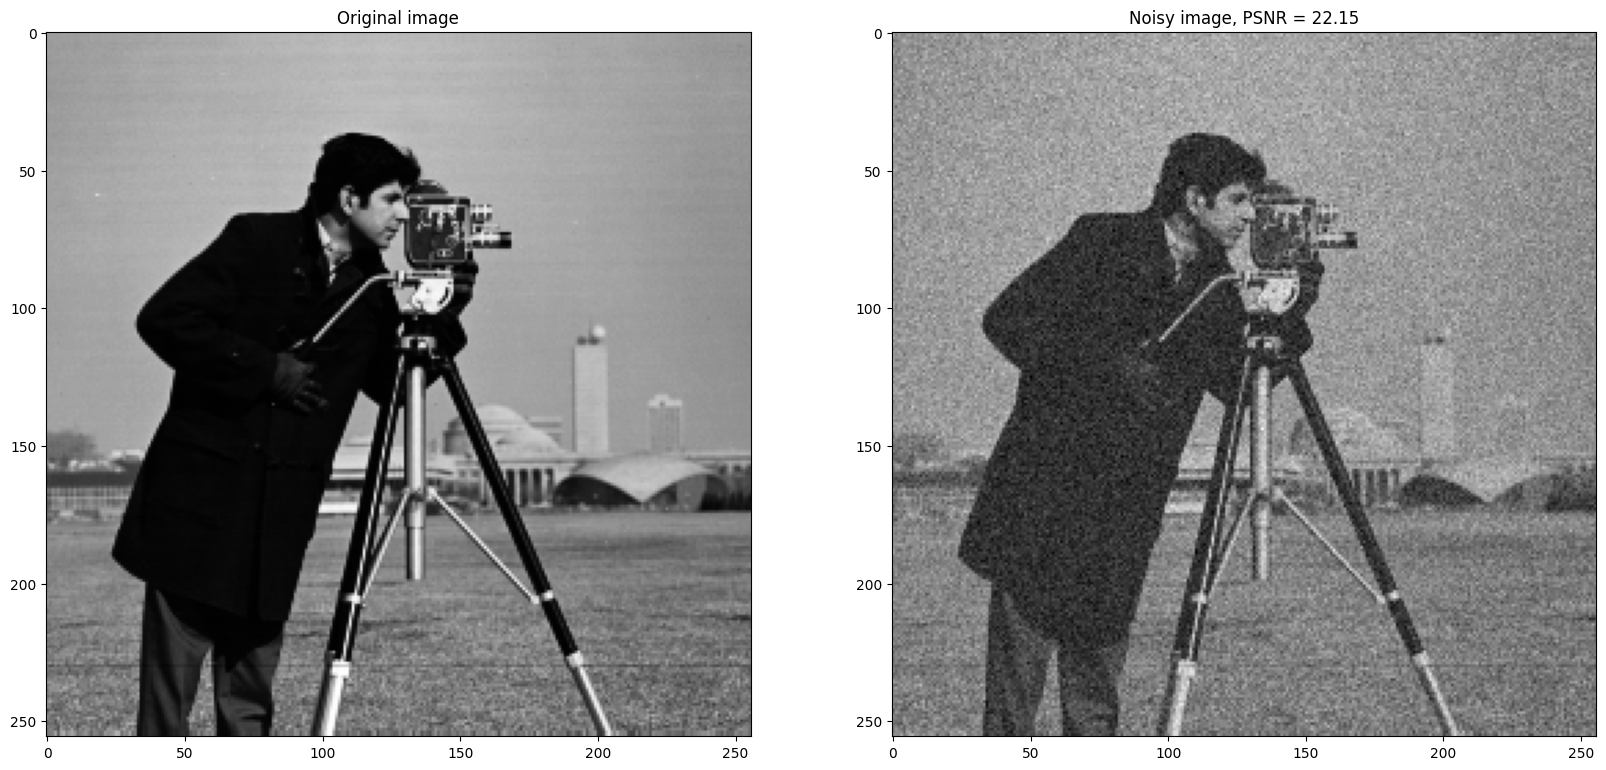

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

In [17]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
img_pad = np.pad(noisy_img, pp, mode='symmetric')

Main loop

In [18]:
for i in range(0, imsz[0]):
  for j in range(0, imsz[1]):
        # extrach the patch from img_pad whose center has the location (i, j) in the noisy image
        r = i+pp
        c = j+pp
        # take the patch centered in this pixel, with side of the square = p
        s = img_pad[r-pp:r+pp,c-pp:c+pp]

        # initialize the pixel estimate and the total weights
        pixel_hat = 0
        weight = 0
        for r_bar in range(-H,H):
            for c_bar in range(-H,H):
                r_prime= r + r_bar
                c_prime= c + c_bar

                if r_prime > pp and r_prime < imsz[0]-1+pp and c_prime > pp and c_prime < imsz[1]-1+pp:
                  # extract the patch
                  z = img_pad[r_prime-pp:r_prime+pp,c_prime-pp:c_prime+pp]

                  # compute the distance with the reference patch
                  d = np.linalg.norm(s-z,2)**2

                  # update the weight and the pixel estimate
                  w =  np.exp(- d/ ((sigma_noise**2) * M))
                  #z = z.reshape((pp,pp))
                  pixel_hat += w * z[pp,pp]
                  weight += w

        # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
        img_hat[i, j] = pixel_hat / weight


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 29.09')

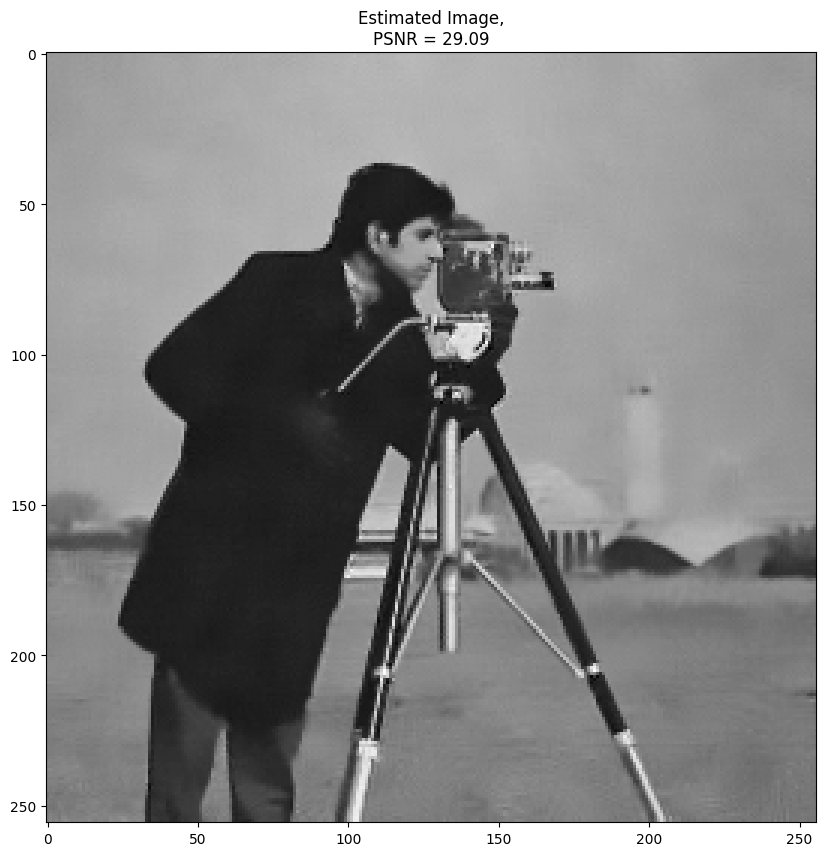

In [19]:
psnr_hat = 10*np.log10(1 / np.mean((img - img_hat) ** 2))
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
